In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from datetime import datetime, timedelta
from control.modules.pcm import PcmControl, PcmParameters
from input_output.alarms import BaseAlarms
from input_output.base import Stamped
from input_output.definitions.simulation import Boundary, TemperatureBoundary
from input_output.modules.pcm import PcmControlValues, PcmSensorValues, PcmSimulationInputs, PcmSimulationOutputs
from orchestration.simulator import Simulator, SimulatorModel
from simulation.models.fmu_paths import pcm_path
import polars as pl

start_time = datetime.fromtimestamp(0)
duration = timedelta(minutes=9)
time_index = pl.datetime_range(
    start_time, start_time + duration, interval="1m", time_unit="us", eager=True
)

simulation_inputs = PcmSimulationInputs(
        pcm_producers_supply=Boundary(
            temperature=Stamped.stamp(70), flow=Stamped.stamp(80)
        ),
        pcm_consumers_supply=TemperatureBoundary(temperature=Stamped.stamp(60)),
        pcm_freshwater_supply=Boundary(
            temperature=Stamped.stamp(40), flow=Stamped.stamp(1)
        ))

control = PcmControl(PcmParameters())

pcm_model = SimulatorModel(
    fmu_path=pcm_path,
    sensor_values_cls=PcmSensorValues,
    control_values_cls=PcmControlValues,
    simulation_outputs_cls=PcmSimulationOutputs,
    simulation_inputs=simulation_inputs,
    control=control,
    alarms=BaseAlarms(),
    tick_duration=timedelta(seconds=1),
    start_time=start_time,
)

simulation = Simulator(pcm_model)

control.to_charging()

result = await simulation.run(int(duration.total_seconds()))

control.to_supplying()

result2 = await simulation.run(int(duration.total_seconds()))

control.to_boosting()

result3 = await simulation.run(int(duration.total_seconds()))

result = result.vstack(result2).vstack(result3)

[WARNING] Warning: The following was detected at time: 1.046309908800334E-28
[WARNING]   PCM_Module_FMU.pcm_module.pcm_pump_supply_flowSplit: Flow splitRatio is negative and far below 0. But it must be between 0 and 1. (is -0.165919)
  Failed condition: pcm_module.pcm_pump_supply_flowSplit.splitRatio_ >= -0.001

[WARNING] Warning: The following was detected at time: 1.046309908800334E-28
[WARNING]   PCM_Module_FMU.pcm_module.pcm_switch_charging_supply_flowJoin: Flow splitRatio is negative and far below 0. But it must be between 0 and 1. (is -0.5)
  Failed condition: pcm_module.pcm_switch_charging_supply_flowJoin.splitRatio >= -0.001

[WARNING] Warning: The following was detected at time: 7.233250765526505E-06
[WARNING]   PCM_Module_FMU.pcm_module.pcm_pump_supply_flowSplit: Flow splitRatio is negative and far below 0. But it must be between 0 and 1. (is -0.001)
  Failed condition: pcm_module.pcm_pump_supply_flowSplit.splitRatio_ >= -0.001



/var/folders/w7/x3ddjmps2dvfqdrygwzccnd00000gn/T/ipykernel_79063/3928423986.py:54: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  result = result.vstack(result2).vstack(result3)


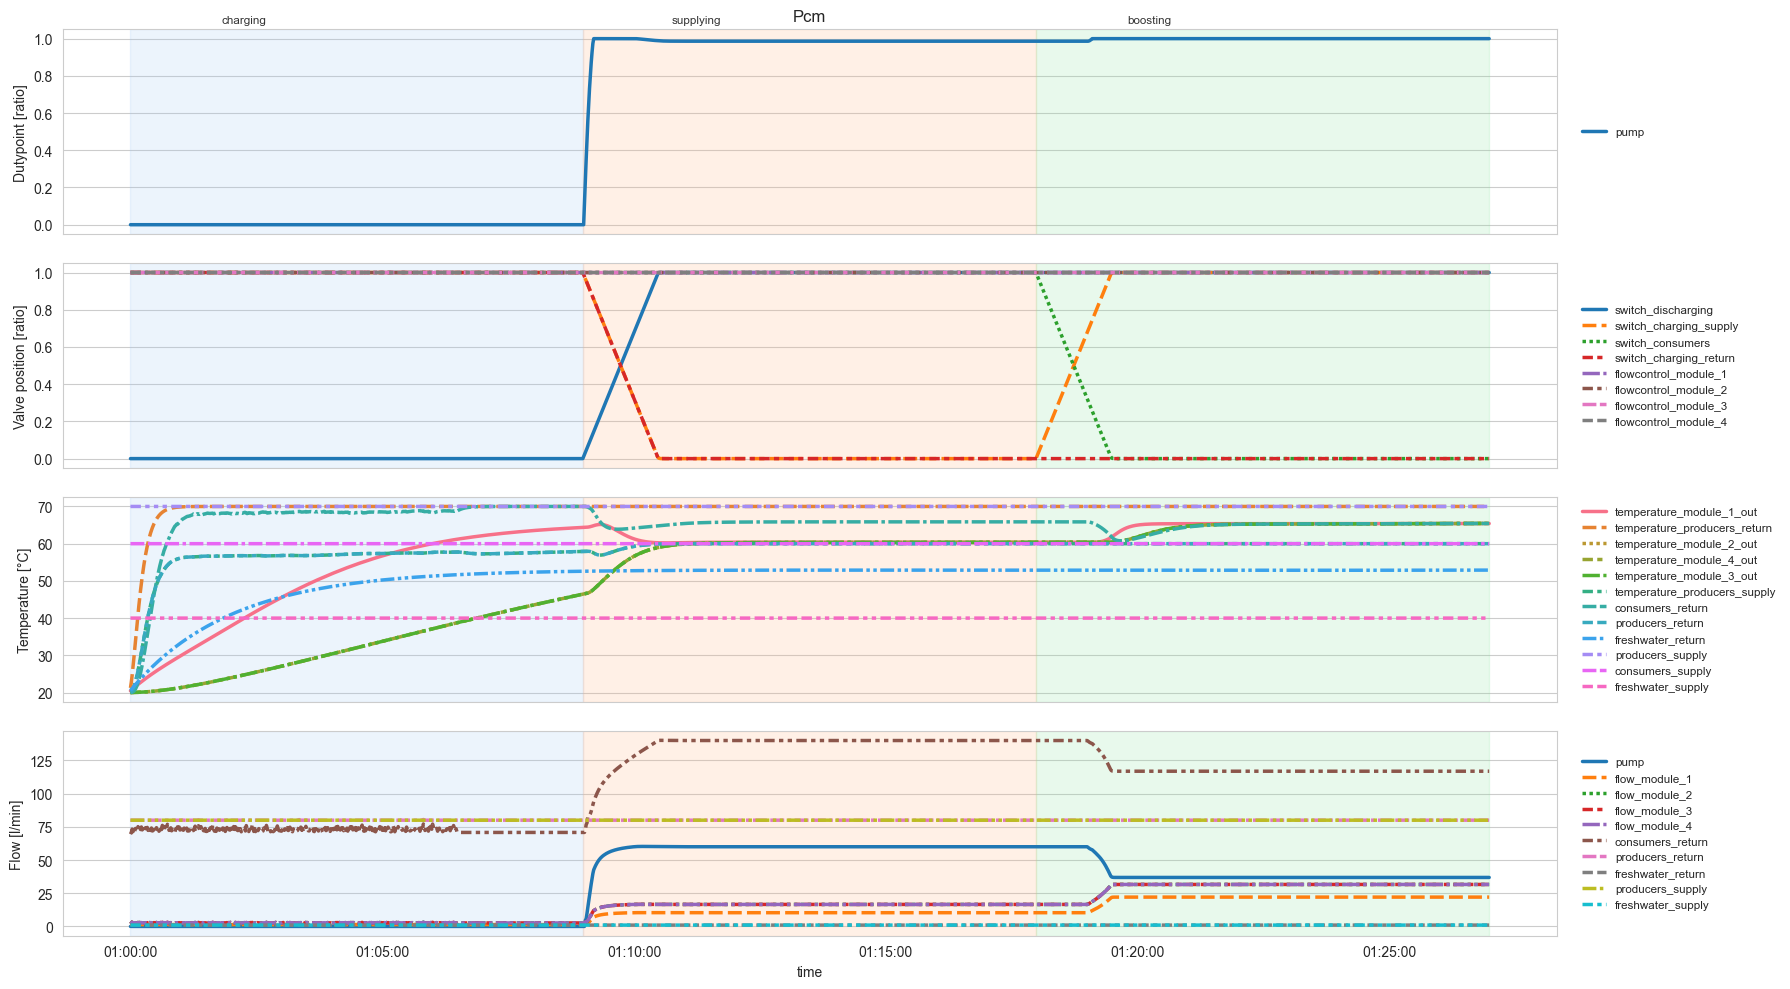

In [6]:
from analysis.analysis_utils import plot_result

plot_result(result, "plots/pcm.png");